In [1]:
import tensorflow as tf
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from tensorflow.keras import layers, models
import pickle
import json

In [2]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("GPU not found. Go to Runtime > Change runtime type > GPU")

GPU detected: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/MLHD_Project/Data/processed_dataset.zip" -d "/content"

In [5]:
PROJECT_DIR = "/content/drive/MyDrive/MLHD_Project"
PROCESSED_DATA_DIR = "/content/processed_dataset"

with open(PROJECT_DIR + "/Data/class_weights.pkl", "rb") as f:
    class_weights = pickle.load(f)

with open(PROJECT_DIR + "/Data/label_to_index.pkl", "rb") as f:
    label_to_index = pickle.load(f)

with open(PROJECT_DIR + "/Data/index_to_label.pkl", "rb") as f:
    index_to_label = pickle.load(f)

In [6]:
def load_dataset(split_path, label_to_index, input_shape=(40, 101), shuffle=True):
    data = []
    labels = []

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if not fname.endswith(".npy"):
                continue

            file_path = os.path.join(label_path, fname)
            spectrogram = np.load(file_path).astype(np.float32)

            # Ensure shape matches
            if spectrogram.shape != input_shape:
                print(f"Skipping {file_path} due to shape mismatch: {spectrogram.shape}")
                continue

            data.append(spectrogram)
            labels.append(label_to_index[label])

    data = np.array(data)[..., np.newaxis]  # Add channel dim
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))

    return dataset

In [7]:
train_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "train"), label_to_index)
val_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "val"), label_to_index, shuffle=False)
test_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "test"), label_to_index, shuffle=False)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
class ResidualCNN:
    def __init__(self, input_shape=(40, 101, 1), num_classes=len(label_to_index)):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _res_block(self, x, filters, stride=1):
        shortcut = x

        # First convolutional layer
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolutional layer
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Shortcut connection
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)

        x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Residual blocks
        x = self._res_block(x, 32)
        x = self._res_block(x, 64, stride=2)
        x = self._res_block(x, 128, stride=2)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)
        return model

    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def get_model(self):
        return self.model

In [9]:
residual_cnn = ResidualCNN(input_shape=(40, 101, 1), num_classes=len(label_to_index))
residual_cnn.compile()
model = residual_cnn.get_model()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.4023 - loss: 2.2062 - val_accuracy: 0.8426 - val_loss: 0.5741
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - accuracy: 0.8312 - loss: 0.6040 - val_accuracy: 0.7244 - val_loss: 0.9605
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.8768 - loss: 0.4340 - val_accuracy: 0.9003 - val_loss: 0.3418
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - accuracy: 0.9003 - loss: 0.3513 - val_accuracy: 0.9158 - val_loss: 0.3039
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - accuracy: 0.9112 - loss: 0.3068 - val_accuracy: 0.8977 - val_loss: 0.3413
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9203 - loss: 0.2783 - val_accuracy: 0.9215 - val_loss: 0.2739
Epoch 7/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.9279 - loss: 0.2424 - val_accuracy: 0.9161 - val_loss: 0.3017
Epoch 8/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9319 -

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9508 - loss: 0.1675

Test accuracy: 0.9452
Test loss: 0.1822


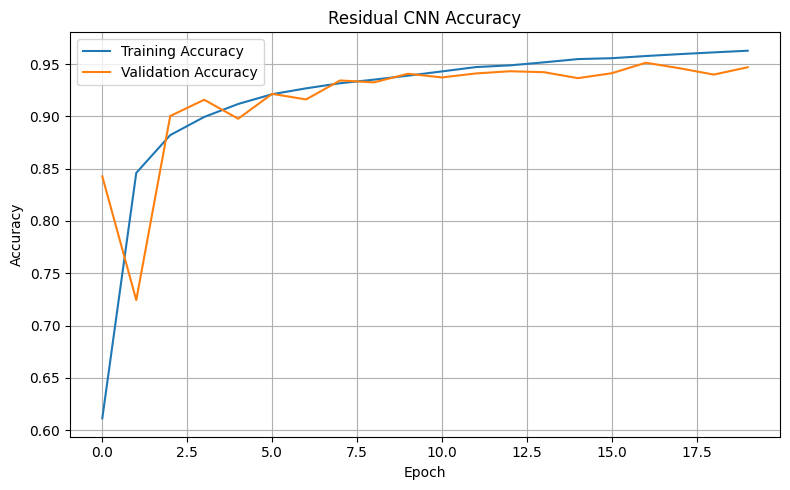

In [11]:
history_dict = history.history
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Residual CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/residual_cnn_accuracy.png")
plt.show()

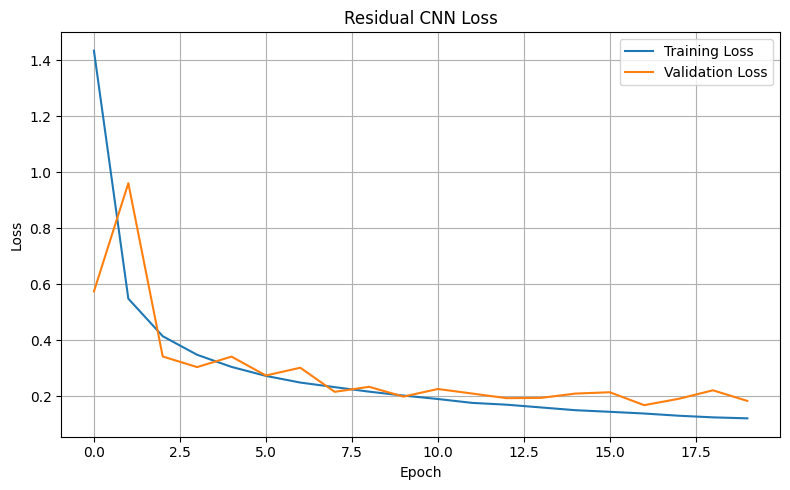

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Residual CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/residual_cnn_loss.png")
plt.show()

In [13]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9470 - loss: 0.1821

Validation accuracy: 0.9469
Validation loss: 0.1832


In [14]:
model_name = "residual_cnn"
drive_dir = f"/content/drive/MyDrive/MLHD_Project/{model_name}"
os.makedirs(drive_dir, exist_ok=True)

model.save(os.path.join(drive_dir, f"{model_name}_model.keras"))
model.save_weights(os.path.join(drive_dir, f"{model_name}.weights.h5"))

history_path = os.path.join(drive_dir, "training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

metadata = {
    "model_name": model_name,
    "epochs": len(history.history["accuracy"]),
    "final_train_acc": round(history.history["accuracy"][-1], 4),
    "final_val_acc": round(history.history["val_accuracy"][-1], 4),
    "input_shape": model.input_shape,
    "output_shape": model.output_shape,
    "num_params": model.count_params(),
}
metadata_path = os.path.join(drive_dir, f"metadata_{model_name}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40, 101, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 40, 101, 32)    │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 40, 101, 32)    │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 40, 101, 32)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 101, 32)    │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 40, 101, 32)    │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 40, 101, 32)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 40, 101, 32)    │          9,248 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 40, 101, 32)    │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 101, 32)    │              0 │ batch_normalization_2… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 40, 101, 32)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 20, 51, 64)     │         18,496 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 20, 51, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 20, 51, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 20, 51, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 20, 51, 64)     │          2,112 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 20, 51, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 937,259 (3.58 MB)

 Trainable params: 311,971 (1.19 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 623,944 (2.38 MB)